In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import numpy as np
import pandas as pd
import random as rn
import os

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.layers
from keras import optimizers
from keras.layers import Activation, Lambda, Input
from keras.layers import Conv1D, SpatialDropout1D, Flatten
from keras.layers import Convolution1D, Dense, Reshape, AveragePooling1D, GlobalAveragePooling1D
from keras.models import Input, Model
from typing import List, Tuple

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [6]:
# reproducibility

def all_seed(seed_num):
    np.random.seed(seed_num)
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED']=str(seed_num)
    tf.random.set_seed(seed_num)

seed_num = 42
all_seed(seed_num)

In [7]:
train = pd.read_csv('/content/drive/MyDrive/Speech_classification/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Speech_classification/test.csv')

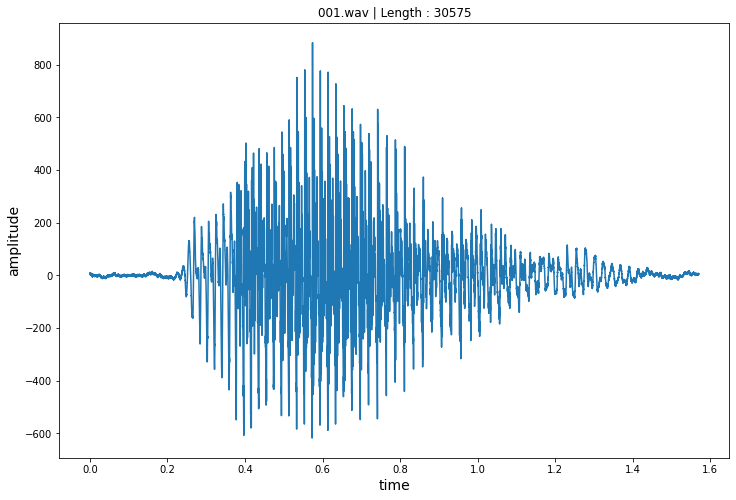

In [8]:
a_filename = '/content/drive/MyDrive/Speech_classification/dataset/train/001.wav'
sample_rate, samples = wavfile.read(a_filename)

plt.figure(figsize=(12, 8))
plt.xlabel('time', fontsize = 14)
plt.ylabel('amplitude', fontsize = 14)
plt.title('001.wav | Length : ' + str(len(samples)))
plt.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)
plt.show()

In [9]:
print(sample_rate)
print(np.array(samples, dtype='float64'))

48000
[7. 4. 7. ... 4. 7. 5.]


In [10]:
samples = np.array(samples, dtype='float64')

samples = librosa.resample(samples, sample_rate, 20000)
ipd.Audio(samples, rate=20000)

In [11]:
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


In [12]:
train['label'].unique()

array([9, 0, 1, 8, 7, 4, 5, 2, 6, 3])

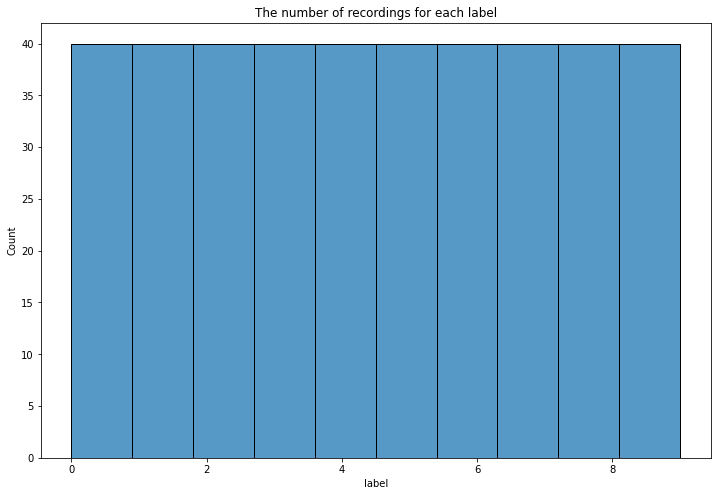

In [13]:
plt.figure(figsize=(12, 8))
sns.histplot(train['label'])
plt.title("The number of recordings for each label")
plt.show()

In [14]:
file_name = train['file_name']

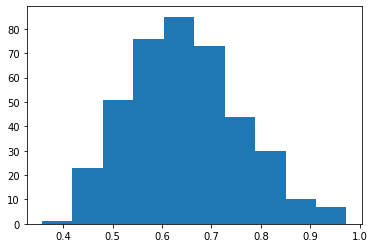

In [15]:
train_path = '/content/drive/MyDrive/Speech_classification/dataset/train/'
duration_of_recordings=[]
for f in file_name:
    sample_rate, samples = wavfile.read(train_path + f)
    duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))
plt.show()

In [16]:
all_shape = []
for f in file_name:
  data, sample_rate = librosa.load(train_path + f, sr=20000)
  all_shape.append(data.shape)

In [17]:
print(all_shape[:5])
print("Max :", np.max(all_shape, axis = 0))
print("Min :", np.min(all_shape, axis = 0))

[(12740,), (13126,), (12910,), (9753,), (17572,)]
Max : [19466]
Min : [7139]


In [18]:
all_wave = []
for f in file_name:
    samples, sample_rate = librosa.load(train_path + f, sr = 40000)
    samples = librosa.resample(samples, sample_rate, 20000)
    if(len(samples)== 20000) : 
      all_wave.append(samples)
    else:
      padding = np.zeros(20000 - len(samples))
      pad_samples = np.concatenate((samples, padding), axis = 0)
      all_wave.append(pad_samples)

In [19]:
print(np.shape(all_wave))
print(all_wave[0])

(400, 20000)
[0.00012188 0.00016871 0.00014333 ... 0.         0.         0.        ]


In [20]:
X = np.array(all_wave).reshape(-1,20000,1)
y = train['label']
print(np.shape(all_wave))

(400, 20000)


In [21]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = seed_num,shuffle=True)

In [22]:
print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_val :", x_val.shape)
print("Shape of y_val :", y_val.shape)

Shape of x_train : (360, 20000, 1)
Shape of y_train : (360,)
Shape of x_val : (40, 20000, 1)
Shape of y_val : (40,)


In [23]:
def gated_activation_units(x):
    tanh_out = Activation('tanh')(x)
    sig_out = Activation('sigmoid')(x)
    return keras.layers.multiply([tanh_out, sig_out])


def residual_block(x, i, num_filters, kernel_size, padding):
    # i: The dilation power of 2


    prev_x = x
    conv = Conv1D(filters=num_filters, kernel_size = kernel_size, dilation_rate = i, padding = padding)(x) # dilated conv
    x = gated_activation_units(conv)  # gated activation units

    x = Convolution1D(num_filters, 1, padding='same')(x)  # skip connection

    res_x = keras.layers.add([prev_x, x])

    return res_x, x  # residual, skip connection

In [24]:
# params
dilations = [1, 2, 4, 8, 16, 32]
dilation_channels = 64
dilation_kernel = 2
padding = "causal"
kernel_size = 2
num_stacks = 1
classes = 10

In [46]:
# wavenet
input = Input(shape=(20000,1))
x = Convolution1D(dilation_channels, dilation_kernel, padding = padding)(input)  # causal conv

skip_connections = []
for k in range(num_stacks):
    for i in dilations:
        x, skip_out = residual_block(x, i, dilation_channels, kernel_size, padding)  # residual and skip connection
        skip_connections.append(skip_out)

x = keras.layers.add(skip_connections) 

x = Activation('relu')(x)

# for classification task
x = Conv1D(64, 4, padding="same", activation = 'relu')(x)
x = AveragePooling1D(4, padding='same')(x)

x = Conv1D(64, 8, padding="same", activation = 'relu')(x)
x = Conv1D(classes, 8, padding='same', activation='relu')(x)

x = AveragePooling1D(8, padding='same')(x)  

x = Conv1D(classes, (int) (20000/32), padding='same')(x)
x = GlobalAveragePooling1D()(x)
output = Activation('softmax')(x)


In [47]:
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 20000, 1)]   0           []                               
                                                                                                  
 conv1d_193 (Conv1D)            (None, 20000, 64)    192         ['input_13[0][0]']               
                                                                                                  
 conv1d_194 (Conv1D)            (None, 20000, 64)    8256        ['conv1d_193[0][0]']             
                                                                                                  
 activation_164 (Activation)    (None, 20000, 64)    0           ['conv1d_194[0][0]']             
                                                                                            

In [48]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [49]:
chk = ModelCheckpoint('/content/drive/MyDrive/Speech_classification/best_wn.pkl', monitor = 'val_accuracy', save_best_only = True, mode = 'max', verbose = 1)

In [ ]:
history = model.fit(x_train, y_train ,epochs = 100, callbacks=[chk], batch_size = 32, validation_data=(x_val,y_val))

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/Speech_classification/best_wn.pkl')

In [ ]:
test_path = '/content/drive/MyDrive/Speech_classification/dataset/test/'
test_filename = test['filename']
all_test = []
for f in file_name:
    samples, sample_rate = librosa.load(test_path + f, sr = 40000)
    samples = librosa.resample(samples, sample_rate, 20000)
    if(len(samples)== 20000) : 
      all_test.append(samples)
    else:
      padding = np.zeros(20000 - len(samples))
      pad_samples = np.concatenate((samples, padding), axis = 0)
      all_test.append(pad_samples)

In [ ]:
test_preds = np.argmax(loaded_model.predict(all_test), axis=-1)